# Netflix-Style Customer Churn Prediction
This project predicts whether a user is likely to leave (churn) a streaming service like Netflix based on user behavior such as viewing time, subscription type, ratings, etc.


# Step 1: Import Libraries

In [ ]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# Step 2: Generate Simulated Netflix-style Churn Dataset
This synthetic dataset mimics a real-world streaming platform's user data, including subscription, usage, ratings, and churn status.


In [ ]:
np.random.seed(42)
n_samples = 1000

# Generate features
data = {
    'Gender': np.random.choice(['Male', 'Female'], n_samples),
    'Age': np.random.randint(18, 75, n_samples),
    'SubscriptionType': np.random.choice(['Basic', 'Standard', 'Premium'], n_samples, p=[0.35, 0.45, 0.20]),
    'MonthlyCharges': np.random.uniform(7.99, 22.99, n_samples).round(2),
    'SubscriptionLengthMonths': np.random.randint(1, 60, n_samples),
    'ViewingHoursPerWeek': np.random.uniform(0.5, 40, n_samples).round(1),
    'ContentDownloadsPerMonth': np.random.randint(0, 30, n_samples),
    'GenrePreference': np.random.choice(['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Documentary', 'Thriller'], n_samples),
    'UserRating': np.random.uniform(1.0, 5.0, n_samples).round(1),
    'MultiDeviceAccess': np.random.choice(['Yes', 'No'], n_samples, p=[0.8, 0.2]),
    'NumProfiles': np.random.randint(1, 6, n_samples),
    'SupportTicketsRaised': np.random.randint(0, 7, n_samples),
    'DaysSinceLastLogin': np.random.randint(0, 120, n_samples)
}

df = pd.DataFrame(data)

# Generate churn logic: higher chance to churn if support tickets high, viewing low, inactive recently
churn_prob = (
    (df['SupportTicketsRaised'] > 3).astype(int) * 0.4 +
    (df['ViewingHoursPerWeek'] < 5).astype(int) * 0.3 +
    (df['DaysSinceLastLogin'] > 60).astype(int) * 0.3 +
    (df['SubscriptionType'] == 'Basic').astype(int) * 0.2
)

# Add random noise and clip between 0 and 1
churn_prob = np.clip(churn_prob + np.random.normal(0, 0.05, n_samples), 0, 1)

# Create Churn label
df['Churn'] = np.random.binomial(1, churn_prob)

df.head()


,Gender,Age,SubscriptionType,MonthlyCharges,SubscriptionLengthMonths,ViewingHoursPerWeek,ContentDownloadsPerMonth,GenrePreference,UserRating,MultiDeviceAccess,NumProfiles,SupportTicketsRaised,DaysSinceLastLogin,Churn
0,Male,71,Premium,10.10,2,7.8,23,Comedy,4.9,Yes,4,1,46,0
1,Female,34,Basic,17.95,24,11.5,8,Drama,4.7,Yes,2,2,4,0
2,Male,26,Basic,11.23,10,9.1,3,Comedy,3.0,Yes,3,2,88,0
3,Male,50,Basic,9.45,38,7.7,14,Comedy,4.2,Yes,3,0,48,1
4,Male,70,Basic,20.92,22,33.1,24,Sci-Fi,1.5,No,4,3,36,1


# Step 3: Exploratory Data Analysis (EDA)
We'll check for missing values, visualize the churn distribution, and explore key relationships such as Churn by Gender, Subscription Type, and Age Group.

Missing Values:
 Gender                      0
Age                         0
SubscriptionType            0
MonthlyCharges              0
SubscriptionLengthMonths    0
ViewingHoursPerWeek         0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
MultiDeviceAccess           0
NumProfiles                 0
SupportTicketsRaised        0
DaysSinceLastLogin          0
Churn                       0
dtype: int64


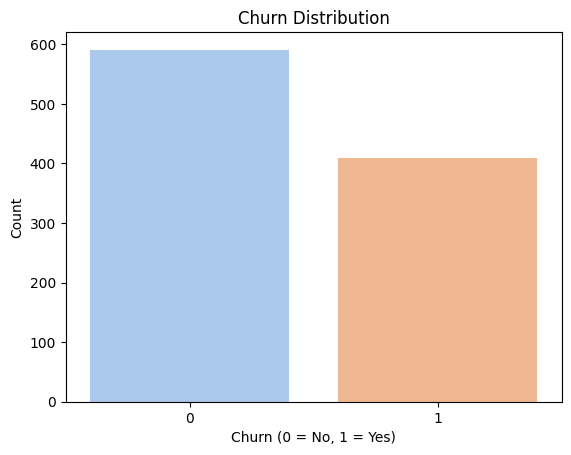

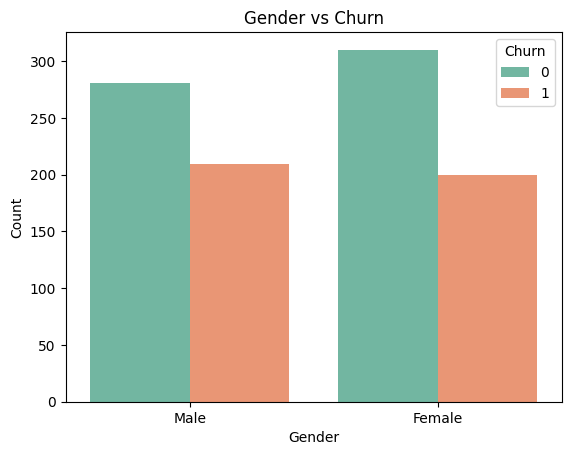

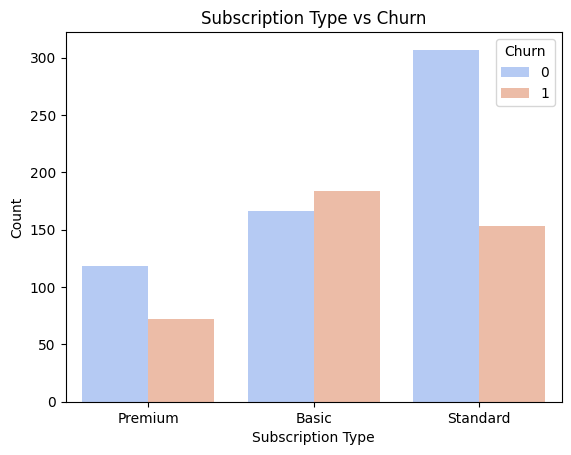

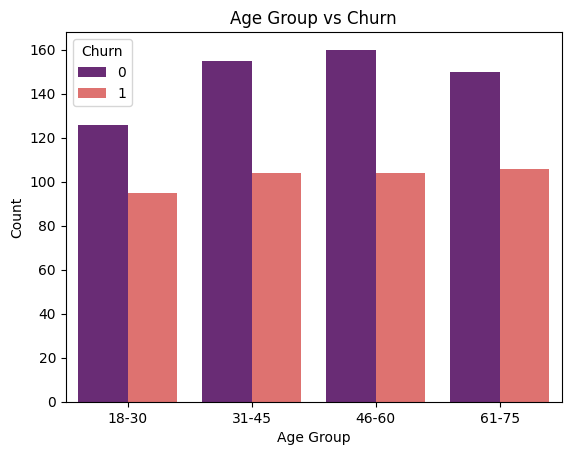

In [ ]:

# Check missing values
print("Missing Values:\n", df.isnull().sum())

# Churn distribution
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Gender vs Churn
sns.countplot(x='Gender', hue='Churn', data=df, palette='Set2')
plt.title("Gender vs Churn")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Subscription Type vs Churn
sns.countplot(x='SubscriptionType', hue='Churn', data=df, palette='coolwarm')
plt.title("Subscription Type vs Churn")
plt.xlabel("Subscription Type")
plt.ylabel("Count")
plt.show()

# Age Group vs Churn
df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 30, 45, 60, 75], labels=['18-30', '31-45', '46-60', '61-75'])
sns.countplot(x='AgeGroup', hue='Churn', data=df, palette='magma')
plt.title("Age Group vs Churn")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()


 # Step 4: Preprocessing Pipeline
We'll handle missing values, scale numeric features, and encode categoricals using Scikit-learn pipelines.


In [ ]:
# Drop AgeGroup (created for plotting only)
df.drop('AgeGroup', axis=1, inplace=True)

# Separate target and features
X = df.drop(['Churn'], axis=1)
y = df['Churn']

# Column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])


 # Step 5: Train-Test Split
We split the dataset into training and test sets (80/20).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


 # Step 6: Model Training and Evaluation
We'll train 3 models: Logistic Regression, Random Forest, and Gradient Boosting, and compare their performance.



🔸 Logistic Regression Results:
Accuracy: 0.76
ROC AUC: 0.8239975196362134
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       118
           1       0.74      0.63      0.68        82

    accuracy                           0.76       200
   macro avg       0.76      0.74      0.75       200
weighted avg       0.76      0.76      0.76       200



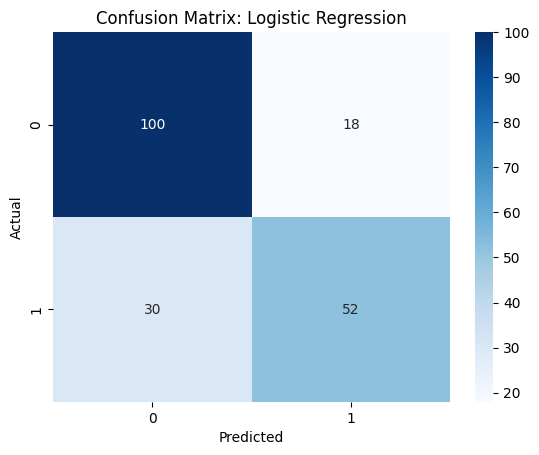


🔸 Random Forest Results:
Accuracy: 0.725
ROC AUC: 0.8016225713104589
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       118
           1       0.71      0.56      0.63        82

    accuracy                           0.72       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.72      0.72      0.72       200



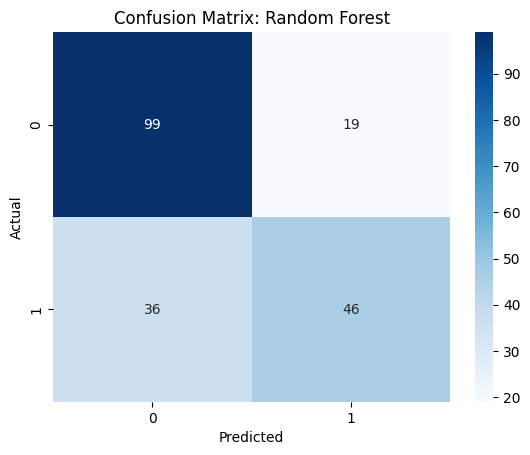


🔸 Gradient Boosting Results:
Accuracy: 0.67
ROC AUC: 0.7745969408846629
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73       118
           1       0.61      0.54      0.57        82

    accuracy                           0.67       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.67      0.67      0.67       200



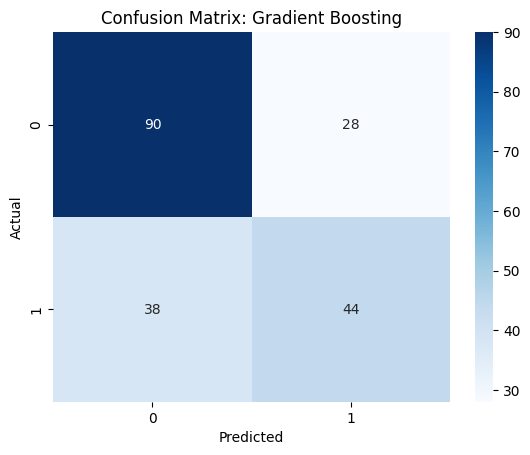

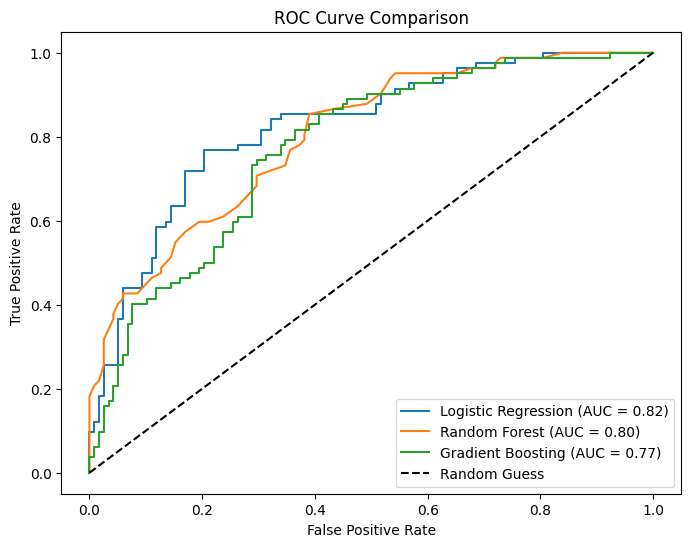

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Dictionary to store ROC curve data
roc_results = {}

# Train, evaluate, and plot confusion matrix for each model
for name, model in models.items():
    clf = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])

    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Print metrics
    print(f"\n🔸 {name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_results[name] = (fpr, tpr, roc_auc_score(y_test, y_prob))

# Plot all ROC curves together
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


 # Step 7: Hyperparameter Tuning (Logistic Regression)
We optimize key hyperparameters using GridSearchCV.


In [ ]:
# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

# Define pipeline with preprocessing and Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(" Best Parameters (Logistic Regression):", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n📌 Final Model Performance (Tuned Logistic Regression):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))


 Best Parameters (Logistic Regression): {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

📌 Final Model Performance (Tuned Logistic Regression):
Accuracy: 0.755
ROC AUC: 0.8283381562629185
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       118
           1       0.73      0.63      0.68        82

    accuracy                           0.76       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.76      0.75       200



# Step 8: Model Saving.

In [ ]:
# Save best model
import joblib
joblib.dump(best_model, 'churn_prediction_model.pkl')
# Load the model
model = joblib.load('churn_prediction_model.pkl')
